# Build CNN

In [33]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale

from tensorflow import keras, random
from tensorflow.keras import layers

# for working with audio data
import librosa, librosa.display

In [2]:
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

## Data Preparation

In [3]:
# load metadata csv
df = pd.read_csv('../../Data/features_30_sec.csv')
df = df[['filename', 'label']]

# relative path to the directory of audio file genre subfolders
rel_path = '../../Data/genres_original/'

# create relative path to each audio file
df['file_path'] = rel_path + df['label'] + '/' + df['filename']

# drop 'filename' column
df = df.drop(columns='filename')
df.head()

,label,file_path
0,blues,../../Data/genres_original/blues/blues.00000.wav
1,blues,../../Data/genres_original/blues/blues.00001.wav
2,blues,../../Data/genres_original/blues/blues.00002.wav
3,blues,../../Data/genres_original/blues/blues.00003.wav
4,blues,../../Data/genres_original/blues/blues.00004.wav


In [4]:
# this jazz song is corrupted and will be removed
# y, sr = librosa.load(df['file_path'][554])

In [5]:
# drop the corrupted song
df = df.drop(labels=554)

# check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      999 non-null    object
 1   file_path  999 non-null    object
dtypes: object(2)
memory usage: 23.4+ KB


In [6]:
# instantiate, fit, transform multiclass target
le = LabelEncoder()
y = le.fit_transform(df['label'])

# one hot encode multiclass target
output_shape = df['label'].nunique()
y = keras.utils.to_categorical(y, output_shape)

# check shape
y.shape

(999, 10)

In [7]:
# split into a 10% holdout set
X_t, X_hold, y_t, y_hold = train_test_split(df['file_path'], y, random_state=42,
                                            stratify=y, test_size=0.1)

# split into 75% train, 15% test sets
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, random_state=42,
                                                    stratify=y_t, test_size=15/90)

In [8]:
mel_specs = []
for sample in X_train:
    y, sr = librosa.load(sample, duration=20)
    S_dB = librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr), ref=np.min)

    # append to the list and create a new axis for concatenation later 
    # and one for the single amplitude channel
    mel_specs.append(S_dB[np.newaxis,..., np.newaxis])

# concatenate along the first axis; result should be a 4D tensor of shape 
# (#samples, #mels, #frames, #channels)
X_train_mel = np.concatenate(mel_specs,axis=0)

# check shape
X_train_mel.shape

(749, 128, 862, 1)

In [9]:
def get_melsp(X, sample_duration):
    features = []
    for sample in X:
        y, sr = librosa.load(sample, duration=sample_duration)
        S_dB = librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr), ref=np.min)

        # append to the list and create a new axis for concatenation later and one for the single amplitude channel
        features.append(S_dB[np.newaxis,..., np.newaxis])

    # concatenate along the first axis; result should be a 4D tensor of shape (#samples, #mels, #frames, #channels)
    return np.concatenate(features,axis=0)

In [10]:
def get_mfcc(X, sample_duration):
    features = []
    for sample in X:
        y, sr = librosa.load(sample, duration=sample_duration)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)

        # append to the list and create a new axis for concatenation later and one for the single amplitude channel
        features.append(mfcc[np.newaxis,..., np.newaxis])

    # concatenate along the first axis; result should be a 4D tensor of shape 
    # (#samples, #mels, #frames, #channels)
    tensor = np.concatenate(features,axis=0)
    print(tensor.min(), tensor.max())
    tensor_sc = (tensor - tensor.min())/(tensor.max()-tensor.min())
    return tensor_sc

In [11]:
# generate mfcc for train
X_train_mfcc = get_mfcc(X_train, 29.9)
X_train_mfcc.shape

-678.8547 253.68959


(749, 20, 1288, 1)

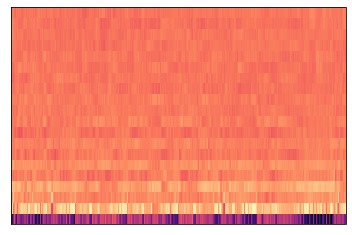

In [12]:
librosa.display.specshow(X_train_mfcc[300,:,:,0])

In [13]:
# define input shape
input_shape = X_train_mfcc.shape[1:]

In [14]:
# generate mfcc for test
X_test_mfcc = get_mfcc(X_test, 29.9)

-673.7394 264.07275


## First Model - Simple Multi-Layer Perceptron

In [24]:
simple = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(1000, activation='relu'),
        layers.Dense(1000, activation='relu'),
        layers.Dense(1000, activation='relu'),
        layers.Dense(10, activation='softmax')
])
simple.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 25760)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 1000)              25761000  
_________________________________________________________________
dense_17 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_18 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_19 (Dense)             (None, 10)                10010     
Total params: 27,773,010
Trainable params: 27,773,010
Non-trainable params: 0
_________________________________________________________________


In [25]:
batch = int(X_train_mfcc.shape[0]/20)
epochs = 15

# Compiling our model
simple.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [26]:
simple_history = simple.fit(X_train_mfcc, 
                    y_train, 
                    batch_size=batch,
                    epochs=epochs, 
                    validation_data=(X_test_mfcc, y_test))

Epoch 1/15
21/21 [==============================] - 5s 238ms/step - loss: 18.6712 - accuracy: 0.0988 - val_loss: 4.2366 - val_accuracy: 0.1000
Epoch 2/15
21/21 [==============================] - 5s 232ms/step - loss: 2.6980 - accuracy: 0.1041 - val_loss: 2.3626 - val_accuracy: 0.1000
Epoch 3/15
21/21 [==============================] - 4s 211ms/step - loss: 2.3256 - accuracy: 0.0948 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/15
21/21 [==============================] - 5s 226ms/step - loss: 2.3029 - accuracy: 0.1015 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/15
21/21 [==============================] - 4s 202ms/step - loss: 2.3029 - accuracy: 0.1001 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/15
21/21 [==============================] - 4s 198ms/step - loss: 2.3028 - accuracy: 0.1001 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/15
21/21 [==============================] - 4s 214ms/step - loss: 2.3028 - accuracy: 0.0881 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch

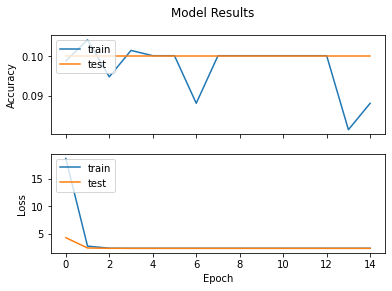

In [27]:
visualize_training_results(simple_history)

## CNN

In [79]:
# set random seed for reproducibility
np.random.seed(42)
random.set_seed(42)

# build sequentially
cnn = keras.Sequential()

# convolutional and max pooling layers with successively more filters
cnn.add(layers.Conv2D(32, (3, 5), activation='relu', padding='same', input_shape=input_shape))
cnn.add(layers.MaxPooling2D((1, 4)))
cnn.add(layers.Conv2D(32, (3, 5), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((1, 4)))
cnn.add(layers.Conv2D(64, (3, 5), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((1, 4)))
cnn.add(layers.Conv2D(64, (3, 5), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((1, 4)))
cnn.add(layers.Conv2D(128, (3, 5), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((2, 3)))
# cnn.add(layers.Conv2D(128, (4, 10), activation='relu', padding='same'))
# cnn.add(layers.MaxPooling2D((2, 2)))

# fully-connected layers for output
cnn.add(layers.Flatten())
cnn.add(layers.Dense(128, activation='relu')),
cnn.add(layers.Dense(10, activation='softmax'))

# compile cnn
cnn.compile(loss='categorical_crossentropy',
            optimizer="adam",
            metrics=['accuracy'])

# take a look at model architecture
cnn.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 20, 1288, 32)      512       
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 20, 322, 32)       0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 20, 322, 32)       15392     
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 20, 80, 32)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 20, 80, 64)        30784     
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 20, 20, 64)      

In [77]:
# fit the model
history = cnn.fit(X_train_mfcc,
                  y_train,
                  epochs=20,
                  batch_size=batch,
                  validation_data=(X_test_mfcc, y_test))

Epoch 1/20
21/21 [==============================] - 74s 4s/step - loss: 2.3051 - accuracy: 0.0935 - val_loss: 2.3024 - val_accuracy: 0.1000
Epoch 2/20
21/21 [==============================] - 80s 4s/step - loss: 2.3001 - accuracy: 0.1295 - val_loss: 2.2782 - val_accuracy: 0.1333
Epoch 3/20
21/21 [==============================] - 78s 4s/step - loss: 2.1147 - accuracy: 0.2043 - val_loss: 1.9148 - val_accuracy: 0.2533
Epoch 4/20
21/21 [==============================] - 89s 4s/step - loss: 1.8691 - accuracy: 0.3138 - val_loss: 1.7787 - val_accuracy: 0.3533
Epoch 5/20
21/21 [==============================] - 77s 4s/step - loss: 1.7665 - accuracy: 0.3471 - val_loss: 1.6977 - val_accuracy: 0.3333
Epoch 6/20
21/21 [==============================] - 73s 3s/step - loss: 1.7168 - accuracy: 0.3591 - val_loss: 1.6722 - val_accuracy: 0.4000
Epoch 7/20
21/21 [==============================] - 78s 4s/step - loss: 1.6911 - accuracy: 0.3605 - val_loss: 1.7425 - val_accuracy: 0.3533
Epoch 8/20
21/21 [==

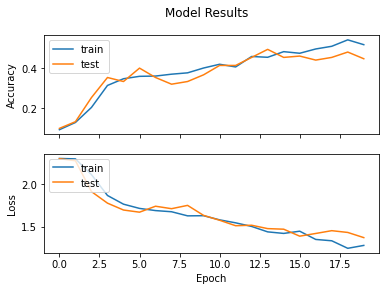

In [78]:
visualize_training_results(history)